# Ensemble Learning of a Hidden Markov Model

In this demo we are interested in Bayesian inference of parameters of a hidden Markov model (HMM). 
Specifically, we consider a first-order HMM with hidden states $s_0, s_1, \dots, s_T$ and observations $x_1, \dots, x_T$ governed by a state transition probability matrix $A$ and an observation probability matrix $B$:

\begin{align*}
    s_t &\sim \mathcal{C}at(A s_{t-1}),\\
    x_t &\sim \mathcal{C}at(B s_t).\\
\end{align*}

We assume three possible states ("red", "green" and "blue"), and the goal is to estimate matrices $A$ and $B$ from a simulated data set. To have a full Bayesian treatment of the problem, both $A$ and $B$ are endowed with priors (Dirichlet distributions on the columns).

## Generate data set

We simulate a sequence of observations by fixing $A$ and $B$ and sampling from the generative model. Specifically, we construct $A$ such that the only possible state transitions are "green" -> "red", "red" -> "blue", "blue" -> "green".
Observation probability matrix $B$ is chosen such that the state is observed under some transition noise.

In [8]:
using ForneyLab

n_samples = 100
A_data = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] # Transition probabilities (some transitions are impossible)
B_data = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] # Observation noise

s_0_data = [1.0, 0.0, 0.0] # Initial state

# Generate some data
s_data = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
x_data = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
s_t_min_data = s_0_data
for t = 1:n_samples
    a = A_data*s_t_min_data
    s_data[t] = sample(ProbabilityDistribution(Categorical, p=a./sum(a))) # Simulate state transition
    b = B_data*s_data[t]
    x_data[t] = sample(ProbabilityDistribution(Categorical, p=b./sum(b))) # Simulate observation
    
    s_t_min_data = s_data[t]
end
;

## Model specification

In our model we assume a relatively strong prior on the observation probability matrix, expressing the prior knowledge that we are most likely to observe the true state. On the other hand, we assume an uninformative prior on the state transition matrix, expressing no prior knowledge about transition probabilities and structure.

In [9]:
g = FactorGraph()

@RV A ~ Dirichlet(ones(3,3)) # Vague prior on transition model
@RV B ~ Dirichlet([10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0]) # Stronger prior on observation model
@RV s_0 ~ Categorical(1/3*ones(3))

s = Vector{Variable}(undef, n_samples) # one-hot coding
x = Vector{Variable}(undef, n_samples) # one-hot coding
s_t_min = s_0
for t = 1:n_samples
    @RV s[t] ~ Transition(s_t_min, A)
    @RV x[t] ~ Transition(s[t], B)
    
    s_t_min = s[t]
    
    placeholder(x[t], :x, index=t, dims=(3,))
end;

## Algorithm generation

We will generate a VMP algorithm to perform inference under the following "structured" (as opposed to "mean-field") posterior factorization:

\begin{align*}
    q(s_0, s_1, \dots, s_T, A, B) = q(s_0, s_1, \dots, s_T)\times q(A)\times q(B).
\end{align*}

Under this factorization, ForneyLab automatically generates the ensemble learning algorithm for HMMs as described in [1].

[1] MacKay, D. J. (1997). Ensemble learning for hidden Markov models (pp. 362-378). Technical report, Cavendish Laboratory, University of Cambridge.

In [10]:
# Generate VMP algorithm with free energy
algo = variationalAlgorithm(A, B, [s_0; s], ids=[:A, :B, :S], free_energy=true)
source_code = algorithmSourceCode(algo, free_energy=true);

## Execution

In [11]:
# Load algorithm
eval(Meta.parse(source_code))

# Initial posterior factors
marginals = Dict{Symbol, ProbabilityDistribution}(
    :A => vague(Dirichlet, (3,3)),
    :B => vague(Dirichlet, (3,3)))

# Initialize data
data = Dict(:x => x_data)
n_its = 20

# Run algorithm
F = Vector{Float64}(undef, n_its)
for i = 1:n_its
    stepS!(data, marginals)
    stepB!(data, marginals)
    stepA!(data, marginals)

    F[i] = freeEnergy(data, marginals)
end
;

## Results

To validate convergence of the inference algorithm, we can inspect the evolution of the cost (free energy) over time.

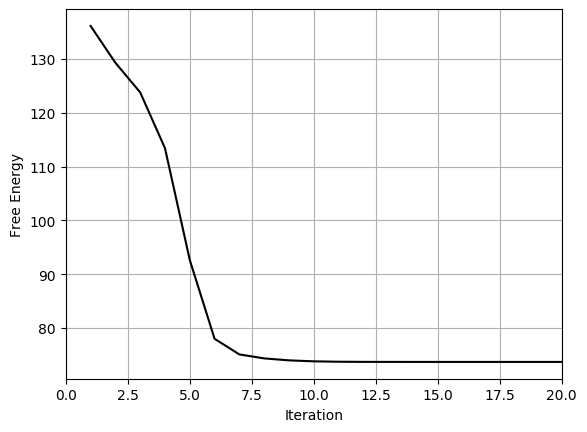

In [12]:
using PyPlot

# Plot free energy
plot(1:n_its, F, color="black")

grid("on")
xlabel("Iteration")
ylabel("Free Energy")
xlim(0,n_its);

To inspect the quality of the inferred state sequence, we plot the simulated process, observations and inferred state sequence.

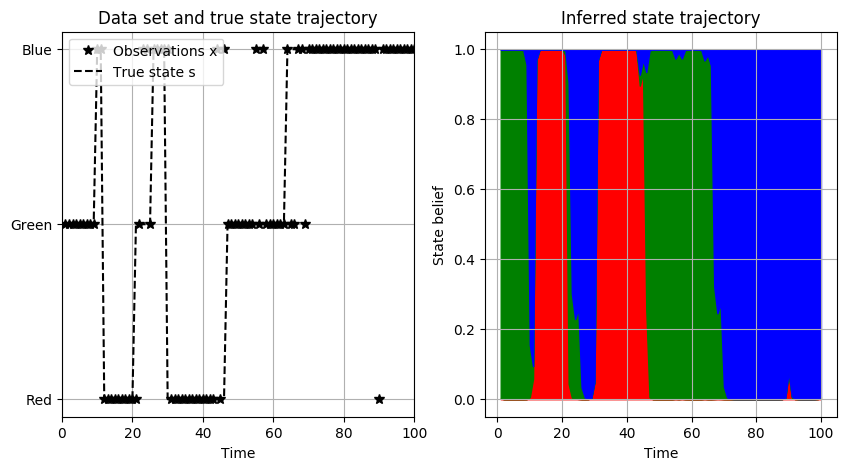

In [13]:
figure(figsize=(10,5))

# Collect state estimates
x_obs = [findfirst(x_i.==1.0) for x_i in x_data]
s_true = [findfirst(s_i.==1.0) for s_i in s_data]

# Plot simulated state trajectory and observations
subplot(121)
plot(1:n_samples, x_obs, "k*", label="Observations x", markersize=7)
plot(1:n_samples, s_true, "k--", label="True state s")
yticks([1.0, 2.0, 3.0], ["Red", "Green", "Blue"])
grid("on")
xlabel("Time")
legend(loc="upper left")
xlim(0,n_samples)
ylim(0.9,3.1)
title("Data set and true state trajectory")

# Plot inferred state sequence
subplot(122)
m_s = [mean(marginals[:s_*t]) for t=1:n_samples]
m_s_1 = [m_s_t[1] for m_s_t in m_s]
m_s_2 = [m_s_t[2] for m_s_t in m_s]
m_s_3 = [m_s_t[3] for m_s_t in m_s]

fill_between(1:n_samples, zeros(n_samples), m_s_1, color="red")
fill_between(1:n_samples, m_s_1, m_s_1 + m_s_2, color="green")
fill_between(1:n_samples, m_s_1 + m_s_2, ones(n_samples), color="blue")
xlabel("Time")
ylabel("State belief")
grid("on")
title("Inferred state trajectory");

We can also compare the estimated state transition probabilities to the true ones using a heatmap:

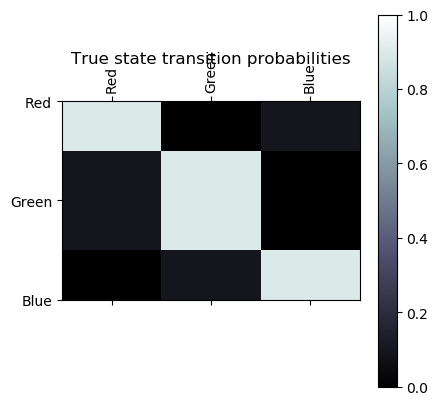

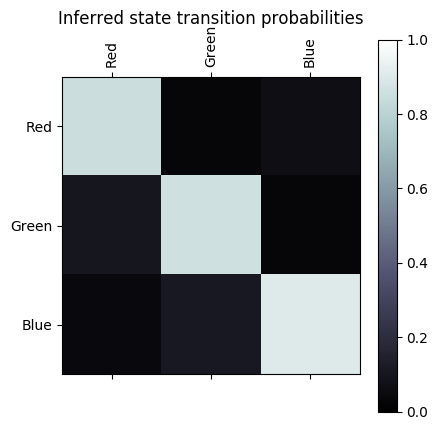

In [19]:
# True state transition probabilities
PyPlot.plt.matshow(A_data, cmap="bone", vmin=0.0, vmax=1.0)
ttl = title("True state transition probabilities")
ttl.set_position([.5, 1.15])
yticks([0, 1, 2], ["Red", "Green", "Blue"])
xticks([0, 1, 2], ["Red", "Green", "Blue"], rotation="vertical")
colorbar()

# Inferred state transition probabilities
PyPlot.plt.matshow(mean(marginals[:A]), cmap="bone", vmin=0.0, vmax=1.0)
ttl = title("Inferred state transition probabilities")
ttl.set_position([.5, 1.15])
yticks([0, 1, 2], ["Red", "Green", "Blue"])
xticks([0, 1, 2], ["Red", "Green", "Blue"], rotation="vertical")
colorbar();

Both the model parameters and the hidden state trajectory are estimated pretty well.